In [7]:
import pandas as pd
import re
import ast
!pip install konlpy
from konlpy.tag import *


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [9]:
!pip install keras-crf
!pip install seqeval
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_crf import CRFModel
from seqeval.metrics import f1_score, classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
path = '/content/drive/MyDrive/Colab Notebooks/AURA2/'

In [12]:
import ast
train_df = pd.read_csv(path +'ner_train_df.csv')
sentences = []
ner_tags = []
for i in range(len(train_df)):
  if i % 10000 == 0:
    print("진행: ",i)
  sentences.append(ast.literal_eval(train_df['sentence'].iloc[i]))
  ner_tags.append(ast.literal_eval(train_df['ner_tags'].iloc[i]))

진행:  0
진행:  10000
진행:  20000
진행:  30000
진행:  40000
진행:  50000
진행:  60000
진행:  70000
진행:  80000
진행:  90000
진행:  100000
진행:  110000
진행:  120000
진행:  130000
진행:  140000
진행:  150000
진행:  160000
진행:  170000
진행:  180000
진행:  190000
진행:  200000
진행:  210000
진행:  220000
진행:  230000
진행:  240000
진행:  250000
진행:  260000
진행:  270000
진행:  280000
진행:  290000
진행:  300000
진행:  310000
진행:  320000
진행:  330000
진행:  340000
진행:  350000


In [13]:

df1 = sentences[:]
df2 = ner_tags[:]


In [14]:

a, X_test, b, y_test_int = train_test_split(df1, df2, test_size = .9, random_state=777)
print(len(a))
print(len(b))


35650
35650


In [15]:

sentences = a[:]
ner_tags = b[:]


In [16]:
print('첫번째 샘플의 문장 :',sentences[0])
print('첫번째 샘플의 레이블 :',ner_tags[0])

첫번째 샘플의 문장 : ['뉴질랜드', "'", '국민', '양', "'", '죽음', '에', '애도', '물결']
첫번째 샘플의 레이블 : ['B-LCP_COUNTRY', 'O', 'O', 'B-AM_MAMMALIA', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 164
샘플의 평균 길이 : 19.866872


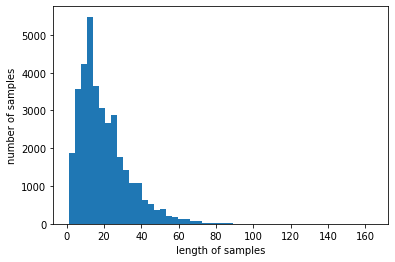

In [17]:
print('샘플의 최대 길이 : %d' % max(len(sentence) for sentence in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(sentence) for sentence in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
# 모든 단어를 사용하며 인덱스 1에는 단어 'OOV'를 할당.
src_tokenizer = Tokenizer(oov_token='OOV')
# 태깅 정보들은 내부적으로 대문자를 유지한 채 저장
tar_tokenizer = Tokenizer(lower=False)

src_tokenizer.fit_on_texts(sentences)
tar_tokenizer.fit_on_texts(ner_tags)

vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 65918
개체명 태깅 정보 집합의 크기 : 287


In [19]:
"""
vocab_size = 4000
src_tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)
"""

"\nvocab_size = 4000\nsrc_tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')\nsrc_tokenizer.fit_on_texts(sentences)\n\ntar_tokenizer = Tokenizer()\ntar_tokenizer.fit_on_texts(ner_tags)\n"

In [20]:
# 정수 인코딩 시행
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [21]:
print(X_data[0])
print(y_data[0])

[10262, 23, 339, 498, 23, 1673, 5, 8034, 8964]
[4, 1, 1, 76, 1, 1, 1, 1, 1]


In [22]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word

index_to_ner[0] = 'PAD'

In [23]:
print(max(len(w) for w in sentences))
print(min(len(w) for w in sentences))
print(np.array([len(w) for w in sentences]).mean())

164
1
19.86687237026648


In [24]:
max_len = 40 # max_len : 샘플의 토큰 길이의 최대를 보고 적당히 정한다.
X_data = pad_sequences(X_data, maxlen=max_len, padding = 'post')
y_data = pad_sequences(y_data, maxlen=max_len, padding = 'post') # 각 토큰에 대해 태깅을 하기에 maxlen이 같다

In [25]:
X_train, X_test, y_train_int, y_test_int = train_test_split(X_data, y_data, test_size = .2, random_state=777)

In [26]:
print(len(X_data))
print(len(X_train))

35650
28520


In [27]:
y_train = to_categorical(y_train_int, num_classes = tag_size)
y_test = to_categorical(y_test_int, num_classes = tag_size)

In [28]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [29]:
with tf.device('/device:GPU:0'):
  embedding_dim = 64
  hidden_units = 32
  dropout_ratio = 0.3

  sequence_input = Input(shape=(max_len,),dtype=tf.int32, name='sequence_input')

  model_embedding = Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim,
                              input_length=max_len)(sequence_input)

  model_bilstm = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(model_embedding)

  model_dropout = TimeDistributed(Dropout(dropout_ratio))(model_bilstm)

  model_dense = TimeDistributed(Dense(tag_size, activation='relu'))(model_dropout)

  base = Model(inputs=sequence_input, outputs=model_dense)
  model = CRFModel(base, tag_size)
  model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

In [30]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit(X_train, y_train_int, batch_size=256, epochs=15, validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
101/101 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.7393 - loss: 72.0568
Epoch 1: val_decode_sequence_accuracy improved from -inf to 0.91071, saving model to bilstm_crf/cp.ckpt
101/101 [==============================] - 40s 279ms/step - decode_sequence_accuracy: 0.7393 - loss: 71.6432 - val_decode_sequence_accuracy: 0.9107 - val_loss: 19.6805
Epoch 2/15
101/101 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9181 - loss: 21.6866
Epoch 2: val_decode_sequence_accuracy improved from 0.91071 to 0.92172, saving model to bilstm_crf/cp.ckpt
101/101 [==============================] - 27s 270ms/step - decode_sequence_accuracy: 0.9181 - loss: 21.6336 - val_decode_sequence_accuracy: 0.9217 - val_loss: 16.4333
Epoch 3/15
101/101 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9213 - loss: 17.7420
Epoch 3: val_decode_sequence_accuracy did not improve from 0.92172
101/101 [==============================] - 27s 

In [33]:
model.load_weights('bilstm_crf/cp.ckpt')

i = 15 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]]))[0] # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
labels = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
어떨               : O       O
때                : O       O
는                : O       O
안                : O       O
들릴               : O       O
정도               : O       O
로                : O       O
조용하게             : O       O
피아노              : B-AF_MUSICAL_INSTRUMENT B-AF_MUSICAL_INSTRUMENT
를                : O       O
쳤는데              : O       O
그                : O       O
감동               : O       O
은                : O       O
너무나도             : O       O
컸다고              : O       O
합니다              : O       O
.                : O       O


In [34]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
from seqeval.metrics import f1_score, classification_report
def sequences_to_tag(sequences):
    result = []
    # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
    for sequence in sequences:
        word_sequence = []
        # 시퀀스로부터 확률 벡터 또는 원-핫 벡터를 하나씩 꺼낸다.
        for pred in sequence:
            # 정수로 변환. 예를 들어 pred가 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            pred_index = np.argmax(pred)            
            # index_to_ner을 사용하여 정수를 태깅 정보로 변환. 'PAD'는 'O'로 변경.
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(word_sequence)
    return result

#y_predicted = model.predict([X_test])
#pred_tags = sequences_to_tag(y_predicted)
#test_tags = sequences_to_tag(y_test)

#print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
#print(classification_report(test_tags, pred_tags))

In [44]:
def sequences_to_tag_for_crf(sequences): 
    result = []
    # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
    for sequence in sequences: 
        word_sequence = []
        # 시퀀스로부터 예측 정수 레이블을 하나씩 꺼낸다.
        for pred_index in sequence:
            # index_to_ner을 사용하여 정수를 태깅 정보로 변환. 'PAD'는 'O'로 변경.
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(word_sequence)
    return result

y_predicted = model.predict(X_test)[0]
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

F1-score: 59.5%
                       precision    recall  f1-score   support

        AFA_ART_CRAFT       0.00      0.00      0.00        17
         AFA_DOCUMENT       0.14      0.09      0.11       193
            AFA_MUSIC       0.00      0.00      0.00        40
      AFA_PERFORMANCE       0.00      0.00      0.00        34
            AFA_VIDEO       0.35      0.38      0.36       164
   AFW_OTHER_PRODUCTS       0.29      0.08      0.13       112
 AFW_SERVICE_PRODUCTS       0.00      0.00      0.00         5
          AF_BUILDING       0.09      0.02      0.03       103
    AF_CULTURAL_ASSET       0.00      0.00      0.00        13
AF_MUSICAL_INSTRUMENT       0.61      0.74      0.67        19
              AF_ROAD       0.00      0.00      0.00        21
         AF_TRANSPORT       0.40      0.52      0.45       171
            AF_WEAPON       0.68      0.41      0.51       106
          AM_AMPHIBIA       0.00      0.00      0.00         4
              AM_BIRD       0.00      